In [1]:
import xml.etree.ElementTree as ET
from xml.dom import minidom
import subprocess
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

class Precursor:
    def __init__(self, decay_constant, beta):
        self.decay_constant = decay_constant
        self.beta = beta
        
class Precomp:
    def __init__(self, time, power, pow_norm, rho, concentrations):
        self.time = time
        self.power = power
        self.pow_norm = pow_norm
        self.rho  = rho
        self.concentrations = concentrations
        
    def set_solve_time(self, solve_time):
        self.solve_time = solve_time
        
class Params:
    def __init__(self, time=None, rho_imp=None, precursors=None, lambda_h=None, 
                 gen_time=None, pow_norm=None, beta_eff=None, 
                 theta=None, gamma_d=None, eta=None, max_iter=1,
                 n_fine_per_coarse = 1):
        self.time = time
        self.rho_imp = rho_imp
        self.precursors = precursors
        self.lambda_h = lambda_h
        self.gen_time = gen_time
        self.pow_norm = pow_norm
        self.beta_eff = beta_eff
        self.theta = theta
        self.gamma_d = gamma_d
        self.eta = eta
        self.max_iter = max_iter
        self.n_fine_per_coarse = n_fine_per_coarse
        
def write_input_xml(precomp, params):
    parareal = ET.Element("parareal", 
                          outpath="examples/epke_output.xml", 
                          max_iterations=str(params.max_iter), 
                          n_fine_per_coarse=str(params.n_fine_per_coarse))
    
    # epke precomputed values (initial conditions)
    epke_output = ET.SubElement(parareal,"epke_output", 
                                n_steps=str(len(params.time)), 
                                n_start=str(1),
                                n_stop=str(len(params.time)))
    ET.SubElement(epke_output, "time").text = ' '.join(map(str,precomp.time))
    ET.SubElement(epke_output, "power").text = ' '.join(map(str,precomp.power))
    ET.SubElement(epke_output, "pow_norm").text = ' '.join(map(str, precomp.pow_norm))
    ET.SubElement(epke_output, "rho").text = ' '.join(map(str,precomp.rho))
    concentrations_element = ET.SubElement(epke_output, "concentrations")
    
    # epke parameters
    epke_input = ET.SubElement(parareal,"epke_input", 
                               n_steps=str(len(params.time)), 
                               theta=str(params.theta), 
                               gamma_d=str(params.gamma_d),
                               eta=str(params.eta))
    
    ET.SubElement(epke_input, "time").text = ' '.join(map(str, params.time))
    ET.SubElement(epke_input, "rho_imp").text = ' '.join(map(str, params.rho_imp))
    
    if (params.gen_time is not None):
        ET.SubElement(epke_input, "gen_time").text = ' '.join(map(str, params.gen_time))
    else:
        ET.SubElement(epke_input, "gen_time", value="1.58e-5")
    
    if (params.pow_norm is not None):
        ET.SubElement(epke_input, "pow_norm").text = ' '.join(map(str, params.pow_norm))
    else:
        ET.SubElement(epke_input, "pow_norm", value="1.0")
    
    ET.SubElement(epke_input, "beta_eff").text = ' '.join(map(str,params.beta_eff))
    ET.SubElement(epke_input, "lambda_h").text = ' '.join(map(str,params.lambda_h))
    
    precursors_element = ET.SubElement(epke_input, "precursors")
    for k, precursor in enumerate(params.precursors):
        precursor_element = ET.SubElement(precursors_element, "precursor", k=str(k))
        ET.SubElement(precursor_element, "decay_constant", value=str(precursor.decay_constant))
        ET.SubElement(precursor_element, "delayed_fraction", value=str(precursor.beta))
        ET.SubElement(concentrations_element, "concentration", 
                      k=str(k)).text = ' '.join(map(str, precomp.concentrations[k])) 
    
    # pretty print and write to xml
    xmlstr = minidom.parseString(ET.tostring(parareal)).toprettyxml(indent=" ")
    
    with open("epke_input.xml", "w") as f:
        f.write(xmlstr)
        
def read_output_from_file(fname):
    tree = ET.parse(fname)
    root = tree.getroot()
    epke_output = root.find('epke_output')
    concentrations_node = epke_output.find('concentrations')
    
    solve_time = float(root.attrib.get('solve_time'))
    
    time = np.fromstring(epke_output.find('time').text, dtype=float, sep=' ')
    power = np.fromstring(epke_output.find('power').text, dtype=float, sep=' ')
    pow_norm = np.fromstring(epke_output.find('pow_norm').text, dtype=float, sep=' ')
    rho = np.fromstring(epke_output.find('rho').text, dtype=float, sep=' ')
    
    concentrations = np.empty(shape=(len(concentrations_node), len(time)), dtype=float)
    
    for child in concentrations_node:
        k = int(child.attrib.get('k'))
        concentrations[k] = np.fromstring(child.text, dtype=float, sep=' ')
        
    precomp = Precomp(time, power, pow_norm, rho, concentrations)
    precomp.set_solve_time(solve_time)

    return precomp

def read_params_from_file(fname):
    tree = ET.parse(fname)
    root = tree.getroot()
    epke_params = root.find('epke_input')
    
    time = np.fromstring(epke_params.find('time').text, dtype=float, sep=' ')
    rho_imp = np.fromstring(epke_params.find('rho_imp').text, dtype=float, sep=' ')
    lambda_h = np.fromstring(epke_params.find('lambda_h').text, dtype=float, sep=' ')
    gen_time = np.fromstring(epke_params.find('gen_time').text, dtype=float, sep=' ')
    pow_norm = np.fromstring(epke_params.find('pow_norm').text, dtype=float, sep=' ')
    beta_eff = np.fromstring(epke_params.find('beta_eff').text, dtype=float, sep=' ')
    
    theta = float(epke_params.attrib.get('theta'))
    gamma_d = float(epke_params.attrib.get('gamma_d'))
    eta = float(epke_params.attrib.get('eta'))
    
    return Params(time, rho_imp, lambda_h, gen_time,
                  pow_norm, beta_eff, theta, gamma_d, eta)

def run_parareal(params, precomp):        
    # write parameters and initial values to xml
    write_input_xml(precomp, params)

    # run the parareal solver
    args = "./epke-run examples/epke_input.xml".split()
    popen = subprocess.Popen(args, cwd="..", stdout=subprocess.PIPE)
    popen.wait()
    while True:
        line = popen.stdout.readline()
        if not line:
            break
        print(line.rstrip().decode('utf-8'))

    return read_output_from_file('epke_output.xml')

In [2]:
def generate_input_file(delta_t):
    # Load PARCS data
    t_load, rho_imp_load, gen_time_load, pow_norm_load, \
    relative_power_load = np.loadtxt("cr_ejection_parcs.txt",
                                     unpack=True,skiprows=2)
    
    # Generate time vector
    t_stop = 1.0
    t = np.linspace(0,t_stop,int(t_stop/delta_t)+1)
    
    # Generate precursors
    precursors = [Precursor(0.0128, 0.02584e-2), Precursor(0.0318, 0.152e-2),
                  Precursor(0.119, 0.13908e-2), Precursor(0.3181, 0.30704e-2),
                  Precursor(1.4027, 0.1102e-2), Precursor(3.9286, 0.02584e-2)]
    beta_sum = sum([p.beta for p in precursors])
    
    # Generate rho imp vector
    rho_imp_parcs = np.interp(t,t_load,rho_imp_load)
    rho_imp = np.copy(rho_imp_parcs)
    
    #rho_max = max(rho_imp_parcs)
    #for i in range(len(rho_imp)):
    #    if (rho_imp[i] >= rho_max):
    #        break
    #rho_imp[i:] = rho_max
    
    # Interpolate PARCS data
    gen_time = np.interp(t,t_load,gen_time_load)
    pow_norm = np.interp(t,t_load,pow_norm_load)
    relative_power = np.interp(t,t_load,relative_power_load)
    
    # Define remaining data
    beta_eff = beta_sum * np.ones(len(t))
    lambduh_h = 0.29 * np.ones(len(t))
    rho_imp *= beta_sum
    gamma_d = 0.0
    #gamma_d = -1.22 * beta_sum
    theta = 1.0
    eta = 1.0
    n_fine_per_coarse = 1
    max_iter = 0
    
    # Create parameters object
    params = Params(t, rho_imp, precursors, lambduh_h, gen_time, 
                    pow_norm, beta_eff, theta, gamma_d,
                    eta, max_iter, n_fine_per_coarse)
    
    # Generate the initial conditions
    precomp_time = [0.0]
    precomp_power = [1e-6]
    precomp_pow_norm = [1]
    precomp_rho = [rho_imp[0]]
    precomp_concentrations = []
    
    for j, precursor in enumerate(precursors):
        initial_concentration = precursor.beta*precomp_power[0]/precursor.decay_constant
        precomp_concentrations.append([initial_concentration])
    
    # Create precomputed values object
    precomp = Precomp(precomp_time, precomp_power, precomp_pow_norm, precomp_rho, precomp_concentrations)
    
    return params, precomp

In [3]:
def run_serial(delta_t):
    # Load PARCS data
    t_load, rho_imp_load, gen_time_load, pow_norm_load, \
    relative_power_load = np.loadtxt("cr_ejection_parcs.txt",
                                     unpack=True,skiprows=2)
    
    # Generate time vector
    t_stop = 1.0
    t = np.linspace(0,t_stop,int(t_stop/delta_t)+1)
    
    # Generate precursors
    precursors = [Precursor(0.0128, 0.02584e-2), Precursor(0.0318, 0.152e-2),
                  Precursor(0.119, 0.13908e-2), Precursor(0.3181, 0.30704e-2),
                  Precursor(1.4027, 0.1102e-2), Precursor(3.9286, 0.02584e-2)]
    beta_sum = sum([p.beta for p in precursors])
    
    # Generate rho imp vector
    rho_imp_parcs = np.interp(t,t_load,rho_imp_load)
    rho_imp = np.copy(rho_imp_parcs)
    
    #rho_max = max(rho_imp_parcs)
    #for i in range(len(rho_imp)):
    #    if (rho_imp[i] >= rho_max):
    #        break
    #rho_imp[i:] = rho_max
    
    # Interpolate PARCS data
    gen_time = np.interp(t,t_load,gen_time_load)
    pow_norm = np.interp(t,t_load,pow_norm_load)
    relative_power = np.interp(t,t_load,relative_power_load)
    
    # Define remaining data
    beta_eff = beta_sum * np.ones(len(t))
    lambduh_h = 0.29 * np.ones(len(t))
    rho_imp *= beta_sum
    gamma_d = 0.0
    #gamma_d = -1.22 * beta_sum
    theta = 1.0
    eta = 1.0
    n_fine_per_coarse = 1
    max_iter = 0
    
    # Create parameters object
    params = Params(t, rho_imp, precursors, lambduh_h, gen_time, 
                    pow_norm, beta_eff, theta, gamma_d,
                    eta, max_iter, n_fine_per_coarse)
    
    # Generate the initial conditions
    precomp_time = [0.0]
    precomp_power = [1e-6]
    precomp_pow_norm = [1]
    precomp_rho = [rho_imp[0]]
    precomp_concentrations = []
    
    for j, precursor in enumerate(precursors):
        initial_concentration = precursor.beta*precomp_power[0]/precursor.decay_constant
        precomp_concentrations.append([initial_concentration])
    
    # Create precomputed values object
    precomp = Precomp(precomp_time, precomp_power, precomp_pow_norm, precomp_rho, precomp_concentrations)
    
    output = run_parareal(params, precomp)
    
    return output

The parareal update is performed as

$u_n^{k+1} = G(u_{n-1}^{k+1}) + F(u_{n-1}^{k}) - G(u_{n-1}^{k})$,

where
- $u$ is the global solution
- $n$ is the global time step index
- $k$ is the parareal iteration index
- $G$ is the coarse solver
- $F$ is the fine solver

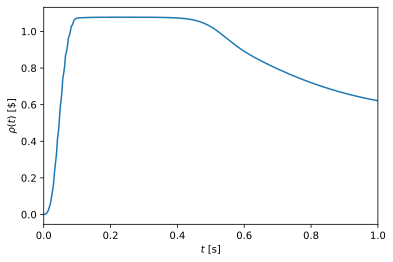

Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml


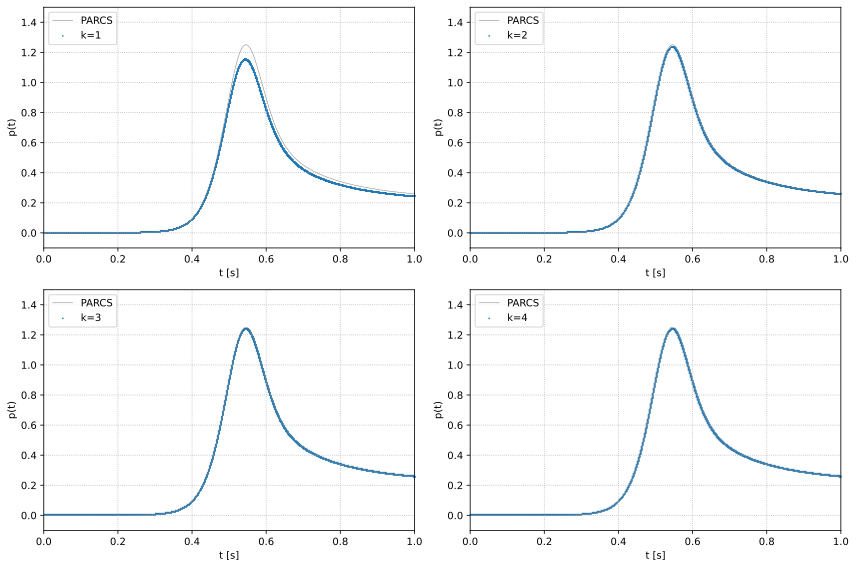

In [21]:
t_load, rho_imp_load, gen_time_load, pow_norm_load, \
    relative_power_load = np.loadtxt("cr_ejection_parcs.txt",
                                     unpack=True,skiprows=2)

plt.plot(t_load,rho_imp_load,label='PARCS')
plt.xlabel('$t$ [s]')
plt.xlim(0,1)
plt.ylabel('$\\rho(t)$ [\$]')
plt.savefig('parareal_ejection_reactivity.pdf')
plt.show()

fig, axes = plt.subplots(2,2,figsize=(12,8))

coarse_delta_t = 1.0/200
params, precomp = generate_input_file(coarse_delta_t)
initial_coarse_output = run_parareal(params, precomp)
coarse_t_out = initial_coarse_output.time
coarse_p_out = initial_coarse_output.power * initial_coarse_output.pow_norm

max_iter_list = [1,2,3,4]

for i in range(len(max_iter_list)):
    params.max_iter = max_iter_list[i]
    params.n_fine_per_coarse = 20
    updated_output = run_parareal(params, precomp)
    
    updated_t_out = updated_output.time
    updated_p_out = updated_output.power * updated_output.pow_norm

    ax1 = axes.flatten()[i]
    
    ax1.plot(t_load,relative_power_load,label='PARCS',color=(0.5, 0.5, 0.5), linewidth=0.5)
    #ax1.scatter(coarse_t_out,coarse_p_out,label='original coarse', marker='x', color='C0')
    ax1.scatter(updated_t_out, updated_p_out, marker='+', 
                label='k='+str(params.max_iter), color='C0', s=1.0, rasterized=True)
    
    ax1.set_xlabel('t [s]')
    ax1.set_ylabel('p(t)')
    ax1.set_xlim(0,1)
    ax1.set_ylim(-.1,1.5)
    ax1.legend(loc=2)
    ax1.grid(linestyle=':')
plt.tight_layout()
plt.savefig('parareal_cr_ejection.pdf', dpi=500)
plt.show()

Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml


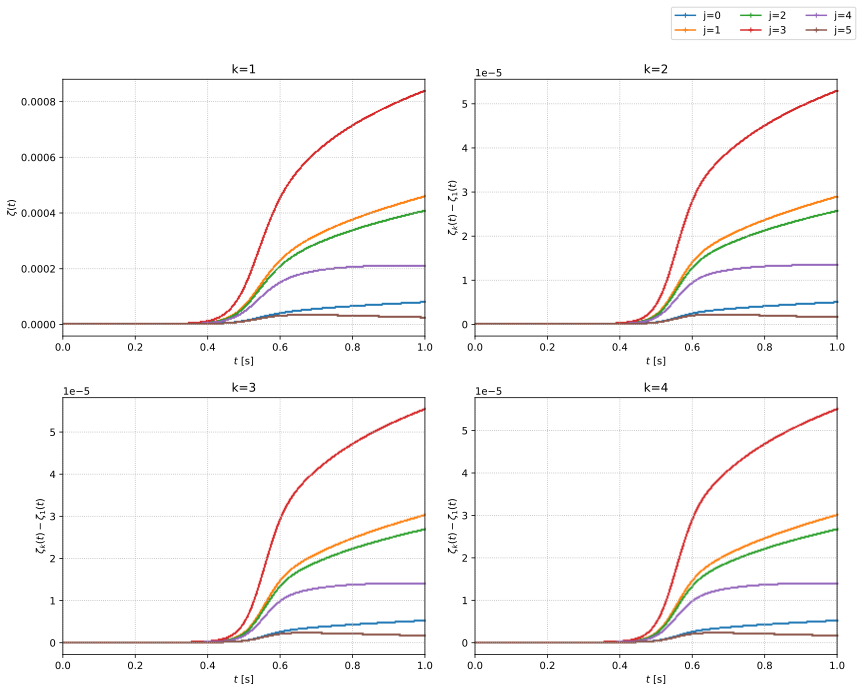

In [19]:
from matplotlib.lines import Line2D

t_load, rho_imp_load, gen_time_load, pow_norm_load, \
    relative_power_load = np.loadtxt("cr_ejection_parcs.txt",
                                     unpack=True,skiprows=2)

fig, axes = plt.subplots(2,2,figsize=(12,9))

coarse_delta_t = 1.0/200
params, precomp = generate_input_file(coarse_delta_t)
initial_coarse_output = run_parareal(params, precomp)
coarse_t_out = initial_coarse_output.time
coarse_p_out = initial_coarse_output.power * initial_coarse_output.pow_norm

max_iter_list = [1,2,3,4]

original_concentrations_out = []

for i in range(len(max_iter_list)):
    params.max_iter = max_iter_list[i]
    params.n_fine_per_coarse = 20
    updated_output = run_parareal(params, precomp)
    
    updated_t_out = updated_output.time
    updated_p_out = updated_output.power * updated_output.pow_norm
    updated_concentrations_out = updated_output.concentrations
    
    if i == 0:
        original_concentrations_out = updated_output.concentrations

    ax1 = axes.flatten()[i]

    for j in range(len(updated_concentrations_out)):
        if i == 0:
            ax1.scatter(updated_t_out, updated_concentrations_out[j], marker='+', 
                        label='j='+str(j),
                        s=1.0, rasterized=True)
        else:
            ax1.scatter(updated_t_out, updated_concentrations_out[j] - original_concentrations_out[j], marker='+', 
                        label='j='+str(j),
                        s=1.0, rasterized=True)

    ax1.set_xlabel('$t$ [s]')
    if i == 0:
        ax1.set_ylabel('$\zeta(t)$')
    else:
        ax1.set_ylabel('$\zeta_k(t) - \zeta_1(t)$')
    ax1.set_xlim(0,1)
    ax1.set_title('k='+str(params.max_iter))
    #ax1.set_ylim(-.1,1.5)
    #ax1.legend(loc=2)
    ax1.grid(linestyle=':')
legend_elements = [Line2D([0], [0], marker='+', color='C0', label='j=0',
                          markerfacecolor='C0', markersize=5),
                   Line2D([0], [0], marker='+', color='C1', label='j=1',
                          markerfacecolor='C1', markersize=5),
                   Line2D([0], [0], marker='+', color='C2', label='j=2',
                          markerfacecolor='C2', markersize=5),
                   Line2D([0], [0], marker='+', color='C3', label='j=3',
                          markerfacecolor='C3', markersize=5),
                   Line2D([0], [0], marker='+', color='C4', label='j=4',
                          markerfacecolor='C4', markersize=5),
                   Line2D([0], [0], marker='+', color='C5', label='j=5',
                          markerfacecolor='C5', markersize=5),
                  ]
fig.legend(handles=legend_elements,loc="lower right", bbox_to_anchor=(1., 1.02) , borderaxespad=0., ncol=3)
fig.tight_layout()
fig.savefig('parareal_ejection_concentrations.pdf', bbox_inches='tight',dpi=500)
plt.show()

Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing 

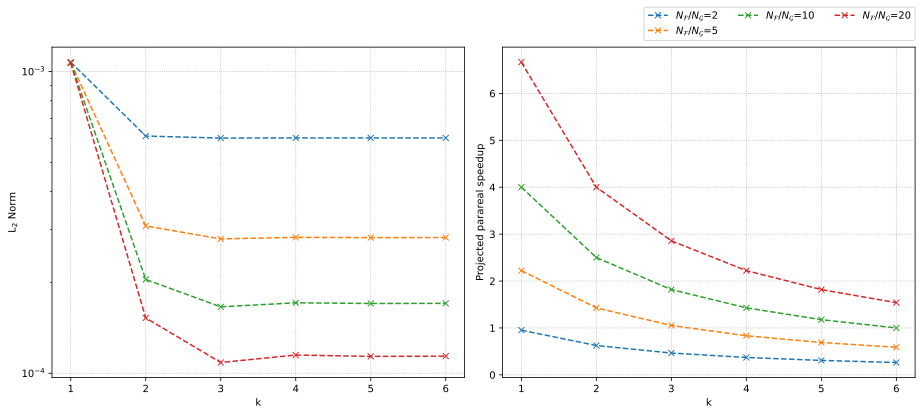

In [6]:
from matplotlib.ticker import MaxNLocator

t_load, rho_imp_load, gen_time_load, pow_norm_load, \
    relative_power_load = np.loadtxt("cr_ejection_parcs.txt",
                                     unpack=True,skiprows=2)

coarse_delta_t = 1.0/200
params, precomp = generate_input_file(coarse_delta_t)
initial_coarse_output = run_parareal(params, precomp)
coarse_t_out = initial_coarse_output.time
coarse_p_out = initial_coarse_output.power * initial_coarse_output.pow_norm

max_iter_list = [1,2,3,4,5,6]
ratio_list = [2,5,10,20]

norm_list = np.zeros((len(ratio_list),len(max_iter_list)))
time_list = np.zeros((len(ratio_list),len(max_iter_list)))

for r, ratio in enumerate(ratio_list):    
    for i in range(len(max_iter_list)):
        params.max_iter = max_iter_list[i]
        params.n_fine_per_coarse = ratio
        updated_output = run_parareal(params, precomp)
        serial_output = run_serial(coarse_delta_t/ratio)
        
        updated_t_out = updated_output.time
        updated_p_out = updated_output.power * updated_output.pow_norm
        
        interp_updated = np.interp(t_load[t_load <= 1.0],updated_t_out,updated_p_out)
        norm_list[r][i] = np.linalg.norm((interp_updated-relative_power_load[t_load <= 1.0])/len(relative_power_load[t_load <= 1.0]))
        time_list[r][i] = serial_output.solve_time / (serial_output.solve_time * ((i+2) / (ratio * 10) * 10 + (i+1)/(20)))

fig, axes = plt.subplots(1,2,figsize=(13,6))
for r in range(len(norm_list)):
    axes[0].plot(np.arange(1,len(max_iter_list)+1),norm_list[r],marker='x',
                 linestyle='--',
                 label='$N_{\mathcal{F}} / N_{\mathcal{G}}$='+str(ratio_list[r]))
    axes[1].plot(np.arange(1,len(max_iter_list)+1),time_list[r],marker='x',
                 linestyle='--',
                 label='$N_{\mathcal{F}} / N_{\mathcal{G}}$='+str(ratio_list[r]))
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[0].set_xlabel('k')
axes[0].set_yscale('log')
axes[0].set_ylabel('L$_2$ Norm')
axes[0].grid(linestyle=':')
axes[1].set_xlabel('k')
#axes[1].set_yscale('log')
axes[1].set_ylabel('Projected parareal speedup')
axes[1].grid(linestyle=':')
plt.legend(loc="lower right", bbox_to_anchor=(1., 1.02) , borderaxespad=0., ncol=3)
plt.tight_layout()
plt.savefig('cr_ejection_convergence.pdf')
plt.show()